In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1. Data Preparation
def prepare_data(csv_path):
    # Read the dataset
    df = pd.read_csv(csv_path)
    
    # Select features (metrics)
    feature_columns = [
        'Download_Speed', 'Reach_Time', 'Time_to_First_Byte', 
        'HTTP_Probe_Duration', 'Page_Load_Time', 'DNS_Query_Time',
        'Status_ID', 'Failed_step_of_scenario_WEB_HEALTH_CHECK',
        'Interrupts_per_second', 'Load_average_15m_avg', 
        'Load_average_1m_avg', 'Load_average_5m_avg',
        'CPU_utilization', 'CPU_idle_time', 'CPU_iowait_time',
        'CPU_system_time', 'CPU_user_time', 'xvda_Disk_utilization',
        'Boot_Space_Used_in_percent', 'Available_memory_in_percent',
        'Memory_utilization', 'Space_Available', 'Boot_Space_Available',
        'Available_memory', 'Total_memory'
    ]
    
    # Prepare features (X) and targets (y)
    X = df[feature_columns]
    y_website = df['website_events']
    y_server = df['server_events']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Encode targets
    le_website = LabelEncoder()
    le_server = LabelEncoder()
    
    y_website_encoded = le_website.fit_transform(y_website)
    y_server_encoded = le_server.fit_transform(y_server)
    
    # Convert to one-hot encoding
    y_website_onehot = tf.keras.utils.to_categorical(y_website_encoded)
    y_server_onehot = tf.keras.utils.to_categorical(y_server_encoded)
    
    return X_scaled, y_website_onehot, y_server_onehot, scaler, le_website, le_server

# 2. Create Deep Learning Model
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 3. Train Models
def train_models(X, y_website, y_server):
    # Split data
    X_train, X_test, y_website_train, y_website_test, y_server_train, y_server_test = train_test_split(
        X, y_website, y_server, test_size=0.2, random_state=42
    )
    
    # Create and train website events model
    website_model = create_model(X.shape[1], y_website.shape[1])
    website_history = website_model.fit(
        X_train, y_website_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Create and train server events model
    server_model = create_model(X.shape[1], y_server.shape[1])
    server_history = server_model.fit(
        X_train, y_server_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate models
    website_eval = website_model.evaluate(X_test, y_website_test)
    server_eval = server_model.evaluate(X_test, y_server_test)
    
    print("\nWebsite Events Model Accuracy:", website_eval[1])
    print("Server Events Model Accuracy:", server_eval[1])
    
    return website_model, server_model, website_history, server_history

# 4. Prediction Function
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    # Scale input metrics
    input_scaled = scaler.transform([input_metrics])
    
    # Get predictions
    website_pred_proba = website_model.predict(input_scaled)
    server_pred_proba = server_model.predict(input_scaled)
    
    # Get top 3 most likely events for each
    top_website_indices = np.argsort(website_pred_proba[0])[-3:][::-1]
    top_server_indices = np.argsort(server_pred_proba[0])[-3:][::-1]
    
    # Convert indices back to event names
    website_events = le_website.inverse_transform(top_website_indices)
    server_events = le_server.inverse_transform(top_server_indices)
    
    return website_events, server_events, website_pred_proba, server_pred_proba

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    X, y_website, y_server, scaler, le_website, le_server = prepare_data('your_dataset.csv')
    
    # Train models
    website_model, server_model, website_history, server_history = train_models(X, y_website, y_server)
    
    # Example prediction with your test metrics
    test_metrics = {
        'Download_Speed': 44984.96562,
        'Reach_Time': 0.0042,
        'Time_to_First_Byte': 0.00537,
        'HTTP_Probe_Duration': 2.245,
        'Page_Load_Time': 0.002252,
        'DNS_Query_Time': 2885,
        'Status_ID': 1,
        'Failed_step_of_scenario_WEB_HEALTH_CHECK': 0,
        'Interrupts_per_second': 213.5782956,
        'Load_average_15m_avg': 0,
        'Load_average_1m_avg': 0,
        'Load_average_5m_avg': 0,
        'CPU_utilization': 0.818577,
        'CPU_idle_time': 99.181423,
        'CPU_iowait_time': 0.016706,
        'CPU_system_time': 0.233918,
        'CPU_user_time': 0.517962,
        'xvda_Disk_utilization': 0.04166729,
        'Boot_Space_Used_in_percent': 16.13612725,
        'Available_memory_in_percent': 41.499557,
        'Memory_utilization': 58.500443,
        'Space_Available': 9337511936,
        'Boot_Space_Available': 719982592,
        'Available_memory': 416624640,
        'Total_memory': 1003925504
    }
    
    # Make predictions
    website_events, server_events, website_probs, server_probs = predict_events(
        website_model, server_model, scaler, le_website, le_server, list(test_metrics.values())
    )
    
    # Print results
    print("\nPredicted Website Events:")
    for event, prob in zip(website_events, website_probs[0][np.argsort(website_probs[0])[-3:][::-1]]):
        print(f"Event {event}: {prob*100:.2f}% probability")
    
    print("\nPredicted Server Events:")
    for event, prob in zip(server_events, server_probs[0][np.argsort(server_probs[0])[-3:][::-1]]):
        print(f"Event {event}: {prob*100:.2f}% probability")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import joblib
import pandas as pd
import numpy as np

# Load the label encoder
le_server = joblib.load('C:\Project-completion\Data-Modeling-Aiops\le_website.joblib')

# Get the classes and their corresponding indices
classes = le_server.classes_
indices = np.arange(len(classes))

# Create a DataFrame
df = pd.DataFrame({
    'event_id': indices,
    'event_name': classes
})

# Save to CSV
df.to_csv('server_events_mapping.csv', index=False)

# Display the mapping
print("\nServer Events Mapping:")
print(df)

# If you want to see the mapping dictionary
mapping_dict = dict(zip(indices, classes))
print("\nMapping Dictionary:")
for event_id, event_name in mapping_dict.items():
    print(f"ID {event_id}: {event_name}")


Server Events Mapping:
    event_id                                         event_name
0          0                      13.126.11.21 is not available
1          1                     13.126.209.90 is not available
2          2                    13.127.178.245 is not available
3          3                    13.233.233.130 is not available
4          4                      3.110.32.172 is not available
5          5                     52.66.107.192 is not available
6          6                       65.2.168.33 is not available
7          7                        65.2.33.65 is not available
8          8  DNS Query Time is High for 13.126.11.21 (More ...
9          9  DNS Query Time is High for 13.233.233.130 (Mor...
10        10  DNS Query Time is High for 13.233.233.130 (Mor...
11        11             Download Speed is Low for 13.126.11.21
12        12  Download Speed is Low for 13.126.11.21 (Less t...
13        13  Download Speed is Low for 13.233.233.130 (Less...
14        14  Do

<>:6: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_3952\2313209955.py:6: SyntaxWarning: invalid escape sequence '\P'
  le_server = joblib.load('C:\Project-completion\Data-Modeling-Aiops\le_website.joblib')



Scaler Parameters:
    feature_index          mean          scale      variance
0               0  1.230060e+03      65.782933  4.327394e+03
1               1  3.632000e-03       0.000228  5.177600e-08
2               2  3.412000e-03       0.000048  2.296000e-09
3               3  1.274600e+00       0.240972  5.806744e-02
4               4  1.161200e-03       0.000044  1.956160e-09
5               5  2.580000e+01       0.979796  9.600000e-01
6               6  1.000000e+00       1.000000  0.000000e+00
7               7  0.000000e+00       1.000000  0.000000e+00
8               8  1.877131e+02      10.752963  1.156262e+02
9               9  0.000000e+00       1.000000  0.000000e+00
10             10  0.000000e+00       1.000000  0.000000e+00
11             11  0.000000e+00       1.000000  0.000000e+00
12             12  6.256196e-01       0.037419  1.400197e-03
13             13  9.937438e+01       0.037419  1.400197e-03
14             14  2.007240e-02       0.006689  4.474006e-05
15  

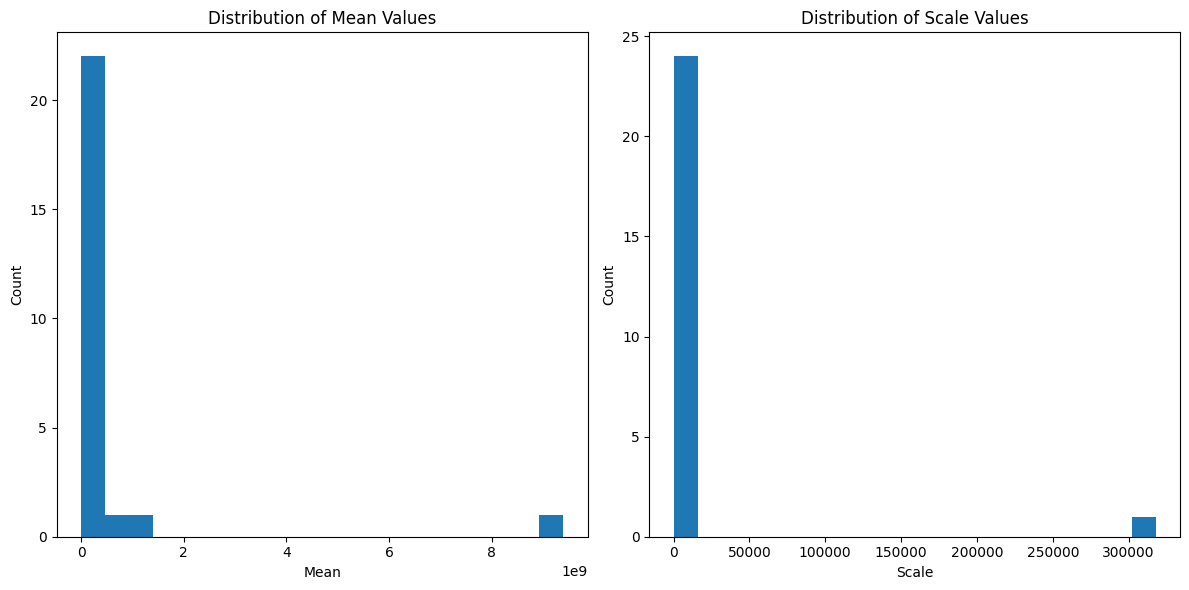

In [15]:
import joblib
import pandas as pd
import numpy as np

# Load the scaler
scaler = joblib.load('C:/Project-completion/Data-Modeling-Aiops/scaler.joblib')

# Create DataFrame with scaling parameters
df = pd.DataFrame({
    'feature_index': range(len(scaler.mean_)),
    'mean': scaler.mean_,
    'scale': scaler.scale_,
    'variance': scaler.var_
})

# Save to CSV
df.to_csv('scaler_parameters.csv', index=False)

# Display the scaling parameters
print("\nScaler Parameters:")
print(df)

# Print summary statistics
print("\nScaler Summary:")
print(f"Number of features: {scaler.n_features_in_}")

# Print feature statistics
print("\nFeature Statistics:")
print(f"Mean values range: {scaler.mean_.min():.2f} to {scaler.mean_.max():.2f}")
print(f"Scale values range: {scaler.scale_.min():.2f} to {scaler.scale_.max():.2f}")

# Optional: Create a visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(scaler.mean_, bins=20)
plt.title('Distribution of Mean Values')
plt.xlabel('Mean')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(scaler.scale_, bins=20)
plt.title('Distribution of Scale Values')
plt.xlabel('Scale')
plt.ylabel('Count')

plt.tight_layout()
plt.show()